In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the datasets
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_cleaned.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_cleaned.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_lifetime_cumulative.tsv')
THE_NUMBERS_PATH_YEARLY = os.path.join(DATA_PATH, 'the_numbers_yearly_score.tsv')

## 1.1 Characters dataset

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars['actor_dob']=pd.to_datetime(df_chars['actor_dob'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


## 1.2 Movie dataset

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t', converters={"m_genres": lambda x: x.strip("[]").split(", ")})
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.drop('m_genre_PCA', axis=1, inplace=True)
df_movies.head(2)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri..."


In [6]:
#df_movies['m_genres'].apply(lambda list_genres: [x for x in list_genres])

# 2. Dataset preparation

## 2.1 Characters dataset

In [7]:
# Keeps just one row if an actor played several roles in a movie
df_chars.drop_duplicates(['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [8]:
# Keep correct actors (you're born before releasing a movie)
df_chars = df_chars.loc[(df_chars['actor_dob'] < df_chars['m_release_date'])]

In [9]:
df_test = df_chars.copy()
df_test.drop_duplicates(subset=['actor_name', 'actor_dob'], keep='first', inplace=True)
df_test = df_test[df_test.duplicated('actor_name', keep=False)]
print("There are {} rows with same actor name but different date of birth.".format(df_test.shape[0]))
# We decided to keep those rows, 
# but add modifications on the ones whose actor name appears in the numbers (to merge the score to the true actor)

There are 515 rows with same actor name but different date of birth.


In [10]:
filter_conditions=(
    ((df_chars['actor_name'] =='Edward Burns') & (df_chars['actor_dob'] =='1879-09-21')) |
    ((df_chars['actor_name'] =='Harrison Ford') & (df_chars['actor_dob'] =='1884-03-16')) |
    ((df_chars['actor_name'] =='Kevin James') & (df_chars['actor_dob'] =='1954-11-17')) # porn actor
)
df_chars = df_chars.loc[~filter_conditions]

In [11]:
filter_conditions=(
    (df_chars['actor_name'] =='Patrick Wilson') & (df_chars['actor_dob'] =='1969-02-01') 
)
df_chars.loc[filter_conditions, 'actor_dob']= '1973-07-03'

In [12]:
filter_conditions=(
    (df_chars['actor_name'] =='Justin Long') & (df_chars['actor_dob'] =='1970-06-29') 
)
df_chars.loc[filter_conditions, 'actor_name']= 'Justin Long 2'

In [13]:
filter_conditions=(
    (df_chars['actor_name'] =='Kenny Rogers') & (df_chars['actor_dob'] =='1964-11-10') 
)
df_chars.loc[filter_conditions, 'actor_dob']= '1938-08-21'

In [14]:
filter_conditions=(
    (df_chars['actor_name'] =='Kevin Smith') & (df_chars['actor_dob'] =='1963-03-16') 
)
df_chars.loc[filter_conditions, 'actor_name']= 'Kevin Smith_NZ'

In [15]:
# Keeps only movies where we have at least two actors (as the interest is coacting)
df_chars = df_chars[df_chars.duplicated('wikipedia_m_ID', keep=False)]

In [16]:
# Keeps only characters from american movies
df_chars = df_chars.merge(df_movies[['wikipedia_m_ID', 'm_name']], how='inner', on='wikipedia_m_ID')

In [17]:
# Drop columns that won't be used at all for the analysis
df_chars.drop(['freebase_character_map', 'freebase_character_id', 'freebase_actor_id', 'freebase_m_ID'], axis=1, inplace=True)

## 2.2 Movie dataset

In [18]:
# Keeps only movies where actors data is available
df_movies = df_movies.merge(df_chars.drop_duplicates('wikipedia_m_ID', keep='first'), how='inner', on=['wikipedia_m_ID', 'm_name', 'm_release_date'])

In [19]:
# Drop columns that won't be used at all for the analysis
df_movies.drop('freebase_m_ID', axis=1, inplace=True)

# 3. PCA

In [20]:
df_genres_m = df_movies.explode('m_genres').dropna(subset='m_genres').copy()
df_genres_m.head()

,wikipedia_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,'Thriller',Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,'Science Fiction',Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,'Horror',Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,'Adventure',Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,'Supernatural',Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0


In [128]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns[1:]

In [129]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m, 'm_genres')
one_hot.drop('', axis=1, inplace=True)
df_genres_one_hot = pd.concat([df_genres_m, one_hot], axis=1)
df_genres_one_hot = df_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

In [130]:
nb_genres_USA=len(genres_one_hot_labels)

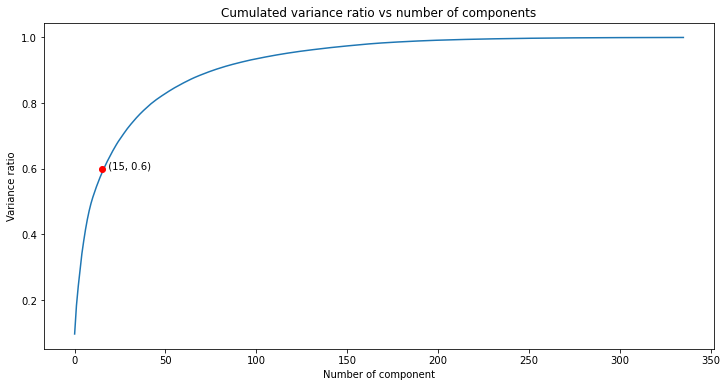

In [131]:
n=nb_genres_USA
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_genres_one_hot)
pca = PCA(n)
pca.fit(X_features)
pca_variance = pca.explained_variance_
pca_variance_ratio = pca.explained_variance_ratio_

csum = np.cumsum(pca_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(csum)
plt.plot(15, 0.6, marker='o', color='red') 
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Cumulated variance ratio vs number of components')
plt.text(15, 0.6, '  ({}, {})'.format(15, 0.6))
plt.show()

In [132]:
n=20
scaler = StandardScaler()
X_features = scaler.fit_transform(df_genres_one_hot)
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [133]:
# number of components
n_pcs = pca.components_.shape[0]

best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

In [134]:
new_space = pca.transform(df_genres_one_hot.values)
new_space = new_space.argmax(axis=1)

df_genres_one_hot['m_genre_PCA'] = new_space
df_genres_one_hot['m_genre_PCA'] = df_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

In [135]:
df_movies_genre_PCA = df_movies.merge(df_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
df_movies_genre_PCA.head()

,wikipedia_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,"'Documentary', 'Culture & Society', 'Gay', 'So..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...",Reporter,1956-12-19,F,NaN,NaN,Alice Barrett,43.0,"'Gay', 'Gay Interest', 'Gay Themed', 'LGBT'"
2,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,['English Language'],United States of America,"['Musical', 'Comedy', 'Black-and-white']",NaN,1908-01-16,F,NaN,NaN,Ethel Merman,30.0,"'Family Film', ""Children's/Family"", 'Comedy', ..."
3,175026,Sarah and Son,1930-01-01,NaN,86.0,['English Language'],United States of America,"['Drama', 'Black-and-white']",NaN,1892-12-24,F,1.57,NaN,Ruth Chatterton,NaN,"'Gay', 'Gay Interest', 'Gay Themed', 'LGBT'"
4,6631279,Little city,1997-04-04,NaN,93.0,['English Language'],United States of America,"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,1971-09-15,M,1.80,NaN,Josh Charles,25.0,"'Gross out', 'Gross-out film', 'Comedy', 'Roma..."


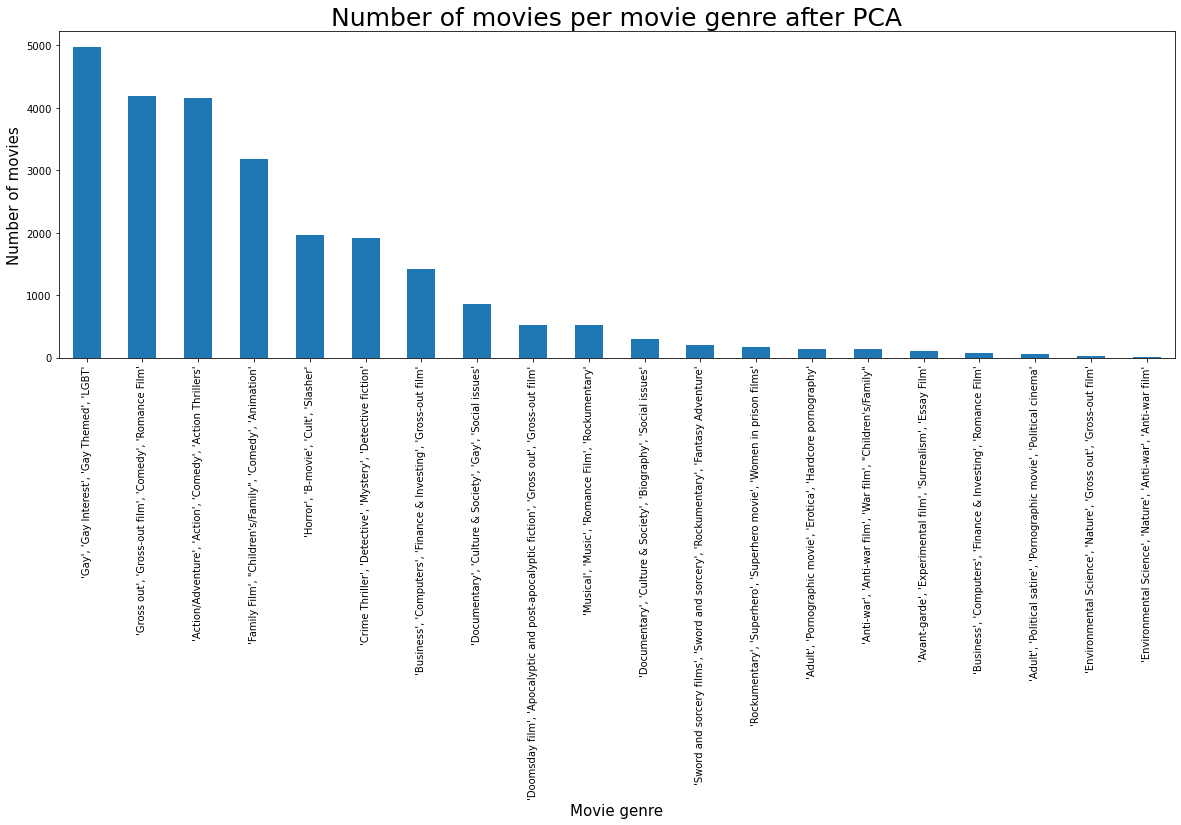

In [136]:
plt.figure(figsize=(20,6))
df_movies_genre_PCA['m_genre_PCA'].value_counts().plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre after PCA', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [137]:
df_tmp = df_movies_genre_PCA.explode('m_genres')
df_tmp[df_tmp['m_genre_PCA'] == "'Gross-out film', 'Gross out', 'Comedy', 'Parody'"]['m_genres'].value_counts().head(15)

Series([], Name: m_genres, dtype: int64)

In [138]:
df_tmp[df_tmp['m_genre_PCA'] == "'Gay', 'Gay Interest', 'Gay Themed', 'LGBT'"]['m_genres'].value_counts().head(30)

'Drama'                4832
'Romance Film'         1379
'Indie'                1307
'Black-and-white'      1039
'Romantic drama'        757
'Comedy'                523
'Crime Fiction'         511
'Silent film'           416
'LGBT'                  319
'Period piece'          310
'Melodrama'             304
'Film adaptation'       274
'Comedy-drama'          266
'War film'              248
'Family Drama'          216
'Biographical film'     213
'Romantic comedy'       210
'Musical'               208
'Television movie'      204
'Biopic [feature]'      172
'Sports'                156
'Biography'             154
'Gay Themed'            145
'Political drama'       144
'Docudrama'             139
'Short Film'            133
'Coming of age'         123
'Comedy film'           119
'Gay'                   118
'Gay Interest'          117
Name: m_genres, dtype: int64

In [139]:
df_tmp[df_tmp['m_genres']=="'Gay'"]['m_genre_PCA'].value_counts()

'Gay', 'Gay Interest', 'Gay Themed', 'LGBT'                         118
'Documentary', 'Culture & Society', 'Gay', 'Social issues'            1
'Adult', 'Pornographic movie', 'Erotica', 'Hardcore pornography'      1
'Family Film', "Children's/Family", 'Comedy', 'Animation'             1
Name: m_genre_PCA, dtype: int64

In [140]:
df_tmp['m_genre_PCA'].value_counts()

'Gross out', 'Gross-out film', 'Comedy', 'Romance Film'                                       21272
'Action/Adventure', 'Action', 'Comedy', 'Action Thrillers'                                    19004
'Gay', 'Gay Interest', 'Gay Themed', 'LGBT'                                                   17026
'Family Film', "Children's/Family", 'Comedy', 'Animation'                                     12477
'Crime Thriller', 'Detective', 'Mystery', 'Detective fiction'                                  9402
'Horror', 'B-movie', 'Cult', 'Slasher'                                                         6975
'Business', 'Computers', 'Finance & Investing', 'Gross-out film'                               4817
'Documentary', 'Culture & Society', 'Gay', 'Social issues'                                     3499
'Doomsday film', 'Apocalyptic and post-apocalyptic fiction', 'Gross out', 'Gross-out film'     2090
'Musical', 'Music', 'Romance Film', 'Rockumentary'                                             1499


# 3. Output as clean CSV

In [ ]:
OUTPUT_FILE = 'characters_filtered.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE)
df_chars.to_csv(OUTPUT_PATH, sep="\t", index=False)

In [ ]:
OUTPUT_FILE = 'american_movies_filtered.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE)
df_movies.to_csv(OUTPUT_PATH, sep="\t", index=False)